# Bairagi et al. (2008) Model Code <a name="top" />

# Table of Contents
1. [Instructions](#instructions)
    1. [Parameter Optimization Against TSST Data Sets](#TSSTInstructions)
    2. [Parameter Optimization Against Basal Data Sets](#basalInstructions)
    3. [Running Without Parameter Optimization](#noOptInstructions)
2. [Imports](#imports)
3. [Parameters and Initial Conditions](#params)
4. [Put Raw Data into Arrays](#rawdata)
    1. [Concentration Scales](#scales)
    2. [Plot Data Sets](#plotdata)
5. [Model Function--Includes ODE Solver](#modelfunction)
6. [Cost Function Definition](#cost)
7. [Run the Optimization](#run)
8. [Save Output to File](#saveoutput)
9. [Compute Means and Std Devations of Parameters and Output as Table](#paramtable)
10. [Plots](#plots)
11. [Reproduce Figure 2 from Paper](#figure2)
12. [No Optimization Run](#no-opt)
13. [Run Optimizations for Multiple Patients](#runMultiple)
14. [Dependencies](#dependencies)

# Instructions <a name="instructions"></a>

## Parameter Optimization Against TSST Data Sets <a name="TSSTInstructions" />

**Note:** To quickly run a cell (or a selection of cells), use the shortcut Shift+Enter (or you can also use the button labeled "Run" in the toolbar at the top).

To run simulations with parameter optimization against TSST data, there is no need to change any cells until the heading **Run the Optimization**. Simply run all cells up to the cell below that heading.

In order to set which data set to optimize parameters against, look for the following line of code:
    
    data_to_match = [nelson.ACTH[:,0], nelson.ACTH[:,1], nelson.cortisol[:,0], nelson.cortisol[:,1]]

In order to run against a patient from the TSST data sets, simply change the list entries to reflect the patient number and subject group. The subject groups are:

- nelson.melancholicACTH & nelson.melancholicCortisol (15 patients)
- nelson.atypicalACTH & nelson.atypicalCortisol (14 patients)
- nelson.neitherACTH & nelson.neitherCortisol (14 patients)
- nelson.healthyACTH & nelson.healthyCortisol (15 patients)

You could also run against the mean of all patients cortisol and ACTH concentration values by using `nelson.ACTH[:,1]` and `nelson.cortisol[:,1]`. Or you can run against the mean of any subgroup using `nelson.<subgroup name>Cortisol_mean[:,1]` and `nelson.<subgroup name>ACTH_mean[:,1]` (for instance `nelson.melancholicCortisol_mean[:,1]` & `nelson.melancholicACTH_mean[:,1]`). 

Note that the first column in each data set is the time steps, so indexing with `[:,0]` is referring to the time. These are the values we need to set as the first (ACTH time steps) and third (cortisol time steps) indices of the `data_to_match` list.

The following are several examples of lists you could use for parameter optimization with explanations:

- `nelson.melancholicACTH[:,0], nelson.melancholicACTH[:,1], nelson.melancholicCortisol[:,0], nelson.melancholicCortisol[:,1]`
    - The 1st patient in the Melancholic subgroup
- `nelson.atypicalACTH[:,0], nelson.atypicalACTH[:,14], nelson.atypicalCortisol[:,0], nelson.atypicalCortisol[:,14]`
    - The 14th patient in the Atypical subgroup
- `nelson.healthyACTH[:,0], nelson.healthyACTH[:,2], nelson.healthyCortisol[:,0], nelson.healthyCortisol[:,2]`
    - The 2nd patient in the Healthy Control group
- `nelson.ACTH[:,0], nelson.ACTH[:,1], nelson.cortisol[:,0], nelson.cortisol[:,1]`
    - The mean data set for all patients (depressed and control)
- `nelson.healthyACTH_mean[:,0], nelson.healthyACTH_mean[:,1], nelson.healthyCortisol_mean[:,0], nelson.healthyCortisol_mean[:,1]`
    - The mean of all control patients
    
Next, you need to decide whether you will optimize any initial conditions (ICs). This can be modified in the function `cost_fun(params)`. In the cost function, we use the first two optimized parameters in the list returned by the optimization algorithm to set the ICs we want to optimize (CRH and GR in this example):

    y0 = [params[0], y0[1], y0[2], params[1]]

We then need to pass only the remaining parameters in the list to the model, along with the updated ICs in y0:

    simData = model(params[1:], y0)
    
If you want to not optimize any ICs, you would simply comment out the two lines above in `cost_fun()`, and uncomment the line:

    #simData = model(params, y0)
    
In that case, you will likely want to change the ICs for CRH and GR, as they will stay the same for every iteration. Under the heading **Run the Optimization**, the following line should be modified to reflect the desired ICs:

    y0 = [0, data_to_match[1][0], data_to_match[3][0]]
    
Be sure to leave the 2nd and 3rd indices unchanged, as these set the ICs to use the initial values of the real-world data set being matched.

At this point, you are ready to run the optimization, so simply run the cells up to the heading **Save Output to File**. This may take some time, so while it is running you can move on to the next steps (if you run a cell while another is processing, it will add it to a queue).

**Note:** You also have the option of using a cost function based on the maximum distance between simulation and real-world data. Simply change SSE_cost to MAX_cost, the instructions for function arguments remain the same.

The cell directly under the heading **Save Output to File** can be changed so that the root filename matches the simulations being run. This root will be used to save all of the various data and figures generated. The current naming scheme would save the files for 5 iterations of parameter optimization against the mean data set from the Nelson with ICs for CRH and GR optimized as:

    filename_root = "bairagiModel_output/nelson-patientMean-5-iterations-ICOpt"

This saves the files in a subfolder specific to this model, which helps keep files organized when running multiple models.

The next few cells create an Excel file containing all of the concentration data and optimized parameter values, and text files containing the initial conditions, parameter bounds and parameter means +- standard deviation across the 5 iterations.

The final step after saving the outputs is to plot the simulations against the real-world data. The cell under the heading **Plots** creates an instance of the Visualizer object from the VeVaPy module called visualize. This will start a dialog which asks for several inputs to generate figures as desired.

Because of the strange behavior of this model, we have to divide the time steps by 20 in order to get minutes. Though the authors report the model in minutes, it actually seems to be in minutes*20 for some reason (based on verification results).

The cell below the initialization of the `Visualizer` object modifies the time steps. Although the time steps are contained in every 4th column starting with 0, we only use the first of these for graphing. Therefore, the following line of code adjusts the time steps to be in minutes:
    
    simData_all[:,0] = [time/20 for time in simData_all[:,0]]

After initialization of the object and modification of the time steps, run its method `make_graphs()`, and it will generate figures using the data you have specified. There are a number of arguments that can be optionally specified for this method, and you can see the recommended values for these in the following function call:

    grapher.make_graphs(yaxis_labels = ["CRH (pmol/L)", "ACTH (pmol/L)", "Cortisol (micromol/L)"],
                    xaxis_labels = ["Time (min)", "Time (min)", "Time (min)"],
                    graph_titles = ["CRH Concentration", "ACTH Concentration", "Cortisol Concentration"],
                    savefile = filename_root+'.png')
                
## Parameter Optimization Against Basal Data Sets <a name="basalInstructions" />

Since these data sets have data points over a 24-hour period (1440 minutes), rather than 140.01 minutes, you will need to change the time interval over which the ODE solver integrates. Strangely, this model seems to be off by a factor of 20 in the time scale, so 140 minutes becomes 2800 time steps--and 1455 minutes becomes 29100 time steps. The reason you add the extra 15 minutes is that you need to make sure that when you interpolate between your simulated data points the line covers every real-world data point so that you don't cause issues when computing the cost function (and the last data point for the Golier cortisol concentration data sets is at 1455 minutes).

To change the time scale, go to the cell directly above the heading **Put Raw Data Into Arrays** and uncomment (delete the # at the start of the line) the lines:

    t_start = -0.5
    t_end = 29100.5
    t_step = 0.5

You'll need to comment out the other definitons for these variables (place a # at the start of the line).

After making this change, you need to again change the `data_to_match` list so that you are matching the basal data set in which you are interested. This time, however, you will also need to change the first and third indices, because we need to tell the function the correct time steps for the data set.

First, choose which data set you wish to match. Here are the options:

- yehuda.controlCortisol
- yehuda.PTSDCortisol
- yehuda.depressedCortisol
- carroll.controlCortisol & carroll.controlACTH
- carroll.LCDepressedCortisol & carroll.LCDepressedACTH (LC = Low Cortisol)
- carroll.HCDepressedCortisol & carroll.HCDepressedACTH (HC = High Cortisol)
- golier.PTSDCortisol & golierPTSDACTH
- golier.nonPTSDTraumaExposedCortisol & golier.nonPTSDTraumaExposedACTH
- golier.nonPTSDNonExposedCortisol & golier.nonPTSDNonExposedACTH
- bremner.abusedPTSDCortisol
- bremner.nonAbusedPTSDCortisol
- bremner.nonAbusedNonPTSDCortisol

**Note:** To see what any of these data sets looks like, click on the **Plot Basal Data Sets** heading in the Table of Contents.

**Note Also:** These data sets all come in smoothed versions (each data point is set to the average of the nearest 5 points of the unsmoothed data). Also, the data sets by Carroll, Golier and Bremner also come in rearranged (or smoothed & rearranged) versions to match the starting time of the Yehuda data (10AM). To use any of these versions, simply append one of the following tags to the end of the data set name (before the indices): `_smooth`, `_rearr`, or `_rearr_smooth`.

First, I will cover what to do with data sets that contain both ACTH and cortisol values, and then afterwards I will cover using the Yehuda and Bremner data sets (which have only cortisol concentration data). Just as with the Nelson data, in all of these data sets the first column is the time step values. This means that if you take any of these arrays and index it with `[:,0]`, you are referring to the time steps. These are the values we need to use as the first (ACTH time steps) and third (cortisol time steps) indices in the `data_to_match` list.

Then for the second and fourth indices, you index the same data sets with `[:,1]` to mean the second column (which contains the mean concentration values for each patient group).

Here are a couple of examples showing lists you can use for optimization:

- `carroll.controlACTH_smooth[:,0], carroll.controlACTH_smooth[:,1], carroll.controlCortisol_smooth[:,0], carroll.controlCortisol_smooth[:,1]`
    - The smoothed Control group mean for the Carroll data set
- `golier.nonPTSDTraumaExposedACTH[:,0], golier.nonPTSDTraumaExposedACTH[:,1], golier.nonPTSDTraumaExposedCortisol[:,0], golier.nonPTSDTraumaExposedCortisol[:,1]`
    - The Trauma-Exposed Control group mean for the Golier data set
    
In order to run simulations against data sets that do not include ACTH concentration data, you will need to change the name of the cost function to `optimize.SSE_cost_noACTH` and then update `data_to_match` to not include the two arguments for ACTH data. To use the Yehuda Control group data, this would look like:

    data_to_match = [yehuda.controlCortisol[:,0], yehuda.controlCortisol[:,1]]
    return optimize.SSE_cost_noACTH(data_to_match[0], data_to_match[1], simData)

For data without ACTH concentrations, you will also need to comment out the current definition of `y0` and uncomment the following line (and change the ICs to the desired values for CRH and ACTH):

    #y0 = [0, 10, data_to_match[1][0]]

At this point, for data with or without ACTH, you're ready to run the parameter optimization, so run all of the cells under the heading **Run the Optimization**.

The cell directly under the heading **Save Output to File** should again have the filename changed to something that reflects the data set you're matching now. For instance, the filename root when matching the smoothed Carroll Control group and optimizing ICs would become:

    filename_root = 'bairagiModel_output/carroll-control-smooth-5-iterations-ICopt'
            
Finally, the cells under the heading **Plots** should be run again to generate graphs. The same process of giving inputs to the object dialog will be performed and then the method `make_graphs()` should be run with any optional arguments desired.

## Running Without Parameter Optimization <a name="noOptInstructions" />

To reproduce Figure 2 from the Bairagi et al. (2008) paper, you don't need to edit any code. Simply run the cells in the section labeled **Reproducing Figure 2 from Paper**.

To run the model with any set of paramaters you desire, without optimization, you can use the cells under the heading **No Optimization Run**. Change the parameters and initial conditions defined under the heading **Parameters and Initial Conditions**, and then run the cell containing the following line:

    data_no_opt = model(authors_params, y0)
    
Then run the cells under **Plots** to create graphs as described in the sections regarding simulations with parameter optimization.

[Back to Top](#top)

# Imports <a name="imports"></a>

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as sco
from scipy import optimize
from scipy.interpolate import interp1d
import mpld3
from tabulate import tabulate
import pandas as pd
from VeVaPy import DEsolver, optimize
from VeVaPy.dataImport import data
from VeVaPy.visualize import Visualizer

[Back to Top](#top)

# Parameters and Initial Conditions <a name="params"></a>

In [2]:
# initial conditions
# order: CRH, ACTH, CORT

# based on: golierPTSD
y0 = [10, 44.22111, 10.68792]

In [3]:
# authors' listed parameter values
b1 = 0.023
b2 = 0.04
b3 = 0.0083
g1 = 0.032
g2 = 0.0013
V = 3
K = 0.048
m = 3
a1 = 0.015
a2 = 0.026

# save these parameter values in an array to use when running without optimization
authors_params = [b1, b2, b3, g1, g2, V, K, m, a1, a2]

In [4]:
# time delay parameters, as used in Figure 2 from the paper
tau1 = 30
tau2 = 60
tau_prime = 10

In [5]:
# compute bounds based on +- 10%
bound = a2
print(bound - bound*.1)
print(bound + bound*.1)

0.023399999999999997
0.0286


In [6]:
# bounds for parameter optimization
# starting with +- 10% since we do not have published ranges in the paper
# order is: b1, b2, b3, g1, g2, V, K, m, a1, a2
bounds = [(0, 20), (0.0207, 0.0253), (0.036000000000000004, 0.044), (0.00747, 0.00913), (0.0288, 0.0352), (0.00117, 0.0014299999999999998), (2.7, 3.3), (0.0432, 0.0528), (2.7, 3.3), (0.0135, 0.0165), (0.023399999999999997, 0.0286)]

In [26]:
# bounds for parameter optimization, including delays in CRH, ACTH and Cortisol
# starting with +- 10% since we do not have published ranges in the paper
# order is: tau0, tau1, tau2, b1, b2, b3, g1, g2, V, K, m, a1, a2
bounds = [(0., 15.), (0., 45.), (0., 90.), (0., 20.), (0.0207, 0.0253), (0.036000000000000004, 0.044), (0.00747, 0.00913), (0.0288, 0.0352), (0.00117, 0.0014299999999999998), (2.7, 3.3), (0.0432, 0.0528), (2.7, 3.3), (0.0135, 0.0165), (0.023399999999999997, 0.0286)]

In [7]:
# define time interval for integration

# time interval and step definition
# all data sets end on 1440.0 or earlier except the Golier cortisol sets,
# they end on 1455.0, so I should set t_end = 1455.01 when matching them
#
# strangely, the model seems to be off by a multiple of 20 in terms of the time step
# in order to match the data for 100 minutes from the authors in Figure 2, I had to run the code for 2000 minutes
#t_start = -0.5
#t_end = 28800.5
#t_step = 0.5

# for matching Nelson data, use these values of t_start, t_end and t_step
#
# the factor of 20 here makes the last time step 2800 for the Nelson data
t_start = -0.5
t_end = 2800.5
t_step = 0.5

[Back to Top](#top)

# Put Raw Data into Arrays <a name="rawdata"></a>

In [8]:
# Create an instance of the data class for each data set contained in the VeVaPy library, and set the time
# scale to minutes.
yehuda = data("yehuda", "minutes")
carroll = data("carroll", "minutes")
golier = data("golier", "minutes")
bremner = data("bremner", "minutes")
nelson = data("nelson", "minutes")

## Concentration Scales <a name="scales" />
This model actually computes CRH, ACTH and Cortisol in pmol/L, rather than having the usual units of micrograms/dL and picograms/mL.

Therefore, we need to convert the scale of the data sets.

### For conversion of data to moles:

ACTH = 2933.444 g/mol

Cortisol = 362.46 g/mol

### Then we need to make the following conversions:
x pg/mL ACTH = x/2933.444e9 mol/L ACTH = x/2.933444e12 mol/L ACTH = x/2.933444 pmol/L ACTH

x micrograms/dL Cortisol = x/362.46e5 mol/L Cortisol = x/3.6246e7 mol/L Cortisol = x/3.6246e-5 pmol/L Cortisol

However, based on the graphs in the paper, I think the authors meant to use micromolar for the cortisol concentrations, because they report ~0.5-1 and this data is 35-40k if we use picomolar. So here I'm using x/3.6246e1 to get micromolar for the cortisol.

In [9]:
carroll.controlACTH[:,1] = np.divide(carroll.controlACTH[:,1], 2.933444)
carroll.controlACTH_rearr[:,1] = np.divide(carroll.controlACTH_rearr[:,1], 2.933444)
carroll.controlACTH_smooth[:,1] = np.divide(carroll.controlACTH_smooth[:,1], 2.933444)
carroll.controlACTH_rearr_smooth[:,1] = np.divide(carroll.controlACTH_rearr_smooth[:,1], 2.933444)

carroll.controlCortisol[:,1] = np.divide(carroll.controlCortisol[:,1], 3.6246e1)
carroll.controlCortisol_rearr[:,1] = np.divide(carroll.controlCortisol_rearr[:,1], 3.6246e1)
carroll.controlCortisol_smooth[:,1] = np.divide(carroll.controlCortisol_smooth[:,1], 3.6246e1)
carroll.controlCortisol_rearr_smooth[:,1] = np.divide(carroll.controlCortisol_rearr_smooth[:,1], 3.6246e1)

carroll.HCDepressedACTH[:,1] = np.divide(carroll.HCDepressedACTH[:,1], 2.933444)
carroll.HCDepressedACTH_rearr[:,1] = np.divide(carroll.HCDepressedACTH_rearr[:,1], 2.933444)
carroll.HCDepressedACTH_smooth[:,1] = np.divide(carroll.HCDepressedACTH_smooth[:,1], 2.933444)
carroll.HCDepressedACTH_rearr_smooth[:,1] = np.divide(carroll.HCDepressedACTH_rearr_smooth[:,1], 2.933444)

carroll.HCDepressedCortisol[:,1] = np.divide(carroll.HCDepressedCortisol[:,1], 3.6246e1)
carroll.HCDepressedCortisol_rearr[:,1] = np.divide(carroll.HCDepressedCortisol_rearr[:,1], 3.6246e1)
carroll.HCDepressedCortisol_smooth[:,1] = np.divide(carroll.HCDepressedCortisol_smooth[:,1], 3.6246e1)
carroll.HCDepressedCortisol_rearr_smooth[:,1] = np.divide(carroll.HCDepressedCortisol_rearr_smooth[:,1], 3.6246e1)

carroll.LCDepressedACTH[:,1] = np.divide(carroll.LCDepressedACTH[:,1], 2.933444)
carroll.LCDepressedACTH_rearr[:,1] = np.divide(carroll.LCDepressedACTH_rearr[:,1], 2.933444)
carroll.LCDepressedACTH_smooth[:,1] = np.divide(carroll.LCDepressedACTH_smooth[:,1], 2.933444)
carroll.LCDepressedACTH_rearr_smooth[:,1] = np.divide(carroll.LCDepressedACTH_rearr_smooth[:,1], 2.933444)

carroll.LCDepressedCortisol[:,1] = np.divide(carroll.LCDepressedCortisol[:,1], 3.6246e1)
carroll.LCDepressedCortisol_rearr[:,1] = np.divide(carroll.LCDepressedCortisol_rearr[:,1], 3.6246e1)
carroll.LCDepressedCortisol_smooth[:,1] = np.divide(carroll.LCDepressedCortisol_smooth[:,1], 3.6246e1)
carroll.LCDepressedCortisol_rearr_smooth[:,1] = np.divide(carroll.LCDepressedCortisol_rearr_smooth[:,1], 3.6246e1)

yehuda.controlCortisol[:,1] = np.divide(yehuda.controlCortisol[:,1], 3.6246e1)
yehuda.controlCortisol_smooth[:,1] = np.divide(yehuda.controlCortisol_smooth[:,1], 3.6246e1)

yehuda.PTSDCortisol[:,1] = np.divide(yehuda.PTSDCortisol[:,1], 3.6246e1)
yehuda.PTSDCortisol_smooth[:,1] = yehuda.PTSDCortisol_smooth[:,1]/3.6246e1

yehuda.depressedCortisol[:,1] = np.divide(yehuda.depressedCortisol[:,1], 3.6246e1)
yehuda.depressedCortisol_smooth[:,1] = np.divide(yehuda.depressedCortisol_smooth[:,1], 3.6246e1)

golier.PTSDCortisol[:,1] = np.divide(golier.PTSDCortisol[:,1], 3.6246e1)
golier.PTSDCortisol_rearr[:,1] = np.divide(golier.PTSDCortisol_rearr[:,1], 3.6246e1)
golier.PTSDCortisol_smooth[:,1] = np.divide(golier.PTSDCortisol_smooth[:,1], 3.6246e1)
golier.PTSDCortisol_rearr_smooth[:,1] = np.divide(golier.PTSDCortisol_rearr_smooth[:,1], 3.6246e1)

golier.PTSDACTH[:,1] = np.divide(golier.PTSDACTH[:,1], 2.933444)
golier.PTSDACTH_rearr[:,1] = np.divide(golier.PTSDACTH_rearr[:,1], 2.933444)
golier.PTSDACTH_smooth[:,1] = np.divide(golier.PTSDACTH_smooth[:,1], 2.933444)
golier.PTSDACTH_rearr_smooth[:,1] = np.divide(golier.PTSDACTH_rearr_smooth[:,1], 2.933444)

golier.nonPTSDTraumaExposedCortisol[:,1] = np.divide(golier.nonPTSDTraumaExposedCortisol[:,1], 3.6246e1)
golier.nonPTSDTraumaExposedCortisol_rearr[:,1] = np.divide(golier.nonPTSDTraumaExposedCortisol_rearr[:,1], 3.6246e1)
golier.nonPTSDTraumaExposedCortisol_smooth[:,1] = np.divide(golier.nonPTSDTraumaExposedCortisol_smooth[:,1], 3.6246e1)
golier.nonPTSDTraumaExposedCortisol_rearr_smooth[:,1] = np.divide(golier.nonPTSDTraumaExposedCortisol_rearr_smooth[:,1], 3.6246e1)

golier.nonPTSDTraumaExposedACTH[:,1] = np.divide(golier.nonPTSDTraumaExposedACTH[:,1], 2.933444)
golier.nonPTSDTraumaExposedACTH_rearr[:,1] = np.divide(golier.nonPTSDTraumaExposedACTH_rearr[:,1], 2.933444)
golier.nonPTSDTraumaExposedACTH_smooth[:,1] = np.divide(golier.nonPTSDTraumaExposedACTH_smooth[:,1], 2.933444)
golier.nonPTSDTraumaExposedACTH_rearr_smooth[:,1] = np.divide(golier.nonPTSDTraumaExposedACTH_rearr_smooth[:,1], 2.933444)

golier.nonPTSDNonExposedCortisol[:,1] = np.divide(golier.nonPTSDNonExposedCortisol[:,1], 3.6246e1)
golier.nonPTSDNonExposedCortisol_rearr[:,1] = np.divide(golier.nonPTSDNonExposedCortisol_rearr[:,1], 3.6246e1)
golier.nonPTSDNonExposedCortisol_smooth[:,1] = np.divide(golier.nonPTSDNonExposedCortisol_smooth[:,1], 3.6246e1)
golier.nonPTSDNonExposedCortisol_rearr_smooth[:,1] = np.divide(golier.nonPTSDNonExposedCortisol_rearr_smooth[:,1], 3.6246e1)

golier.nonPTSDNonExposedACTH[:,1] = np.divide(golier.nonPTSDNonExposedACTH[:,1], 2.933444)
golier.nonPTSDNonExposedACTH_rearr[:,1] = np.divide(golier.nonPTSDNonExposedACTH_rearr[:,1], 2.933444)
golier.nonPTSDNonExposedACTH_smooth[:,1] = np.divide(golier.nonPTSDNonExposedACTH_smooth[:,1], 2.933444)
golier.nonPTSDNonExposedACTH_rearr_smooth[:,1] = np.divide(golier.nonPTSDNonExposedACTH_rearr_smooth[:,1], 2.933444)

bremner.abusedPTSDCortisol[:,1] = np.divide(bremner.abusedPTSDCortisol[:,1], 3.6246e1)
bremner.abusedPTSDCortisol_rearr[:,1] = np.divide(bremner.abusedPTSDCortisol_rearr[:,1], 3.6246e1)
bremner.abusedPTSDCortisol_smooth[:,1] = np.divide(bremner.abusedPTSDCortisol_smooth[:,1], 3.6246e1)
bremner.abusedPTSDCortisol_rearr_smooth[:,1] = np.divide(bremner.abusedPTSDCortisol_rearr_smooth[:,1], 3.6246e1)

bremner.nonAbusedPTSDCortisol[:,1] = np.divide(bremner.nonAbusedPTSDCortisol[:,1], 3.6246e1)
bremner.nonAbusedPTSDCortisol_rearr[:,1] = np.divide(bremner.nonAbusedPTSDCortisol_rearr[:,1], 3.6246e1)
bremner.nonAbusedPTSDCortisol_smooth[:,1] = np.divide(bremner.nonAbusedPTSDCortisol_smooth[:,1], 3.6246e1)
bremner.nonAbusedPTSDCortisol_rearr_smooth[:,1] = np.divide(bremner.nonAbusedPTSDCortisol_rearr_smooth[:,1], 3.6246e1)

bremner.nonAbusedNonPTSDCortisol[:,1] = np.divide(bremner.nonAbusedNonPTSDCortisol[:,1], 3.6246e1)
bremner.nonAbusedNonPTSDCortisol_rearr[:,1] = np.divide(bremner.nonAbusedNonPTSDCortisol_rearr[:,1], 3.6246e1)
bremner.nonAbusedNonPTSDCortisol_smooth[:,1] = np.divide(bremner.nonAbusedNonPTSDCortisol_smooth[:,1], 3.6246e1)
bremner.nonAbusedNonPTSDCortisol_rearr_smooth[:,1] = np.divide(bremner.nonAbusedNonPTSDCortisol_rearr_smooth[:,1], 3.6246e1)

nelson.ACTH[:, 1:] = np.divide(nelson.ACTH[:, 1:], 2.933444)
nelson.cortisol[:, 1:] = np.divide(nelson.cortisol[:, 1:], 3.6246e1)

nelson.atypicalACTH[:, 1:] = np.divide(nelson.atypicalACTH[:, 1:], 2.933444)
nelson.atypicalCortisol[:, 1:] = np.divide(nelson.atypicalCortisol[:, 1:], 3.6246e1)
nelson.melancholicACTH[:, 1:] = np.divide(nelson.melancholicACTH[:, 1:], 2.933444)
nelson.melancholicCortisol[:, 1:] = np.divide(nelson.melancholicCortisol[:, 1:], 3.6246e1)
nelson.neitherACTH[:, 1:] = np.divide(nelson.neitherACTH[:, 1:], 2.933444)
nelson.neitherCortisol[:, 1:] = np.divide(nelson.neitherCortisol[:, 1:], 3.6246e1)
nelson.healthyACTH[:, 1:] = np.divide(nelson.healthyACTH[:, 1:], 2.933444)
nelson.healthyCortisol[:, 1:] = np.divide(nelson.healthyCortisol[:, 1:], 3.6246e1)

nelson.atypicalACTH_mean[:, 1:] = np.divide(nelson.atypicalACTH_mean[:, 1:], 2.933444)
nelson.atypicalCortisol_mean[:, 1:] = np.divide(nelson.atypicalCortisol_mean[:, 1:], 3.6246e1)
nelson.melancholicACTH_mean[:, 1:] = np.divide(nelson.melancholicACTH_mean[:, 1:], 2.933444)
nelson.melancholicCortisol_mean[:, 1:] = np.divide(nelson.melancholicCortisol_mean[:, 1:], 3.6246e1)
nelson.neitherACTH_mean[:, 1:] = np.divide(nelson.neitherACTH_mean[:, 1:], 2.933444)
nelson.neitherCortisol_mean[:, 1:] = np.divide(nelson.neitherCortisol_mean[:, 1:], 3.6246e1)
nelson.healthyACTH_mean[:, 1:] = np.divide(nelson.healthyACTH_mean[:, 1:], 2.933444)
nelson.healthyCortisol_mean[:, 1:] = np.divide(nelson.healthyCortisol_mean[:, 1:], 3.6246e1)
nelson.depressedACTH_mean[:, 1:] = np.divide(nelson.depressedACTH_mean[:, 1:], 2.933444)
nelson.depressedCortisol_mean[:, 1:] = np.divide(nelson.depressedCortisol_mean[:, 1:], 3.6246e1)


## Plot Data Sets <a name="plotdata"></a>

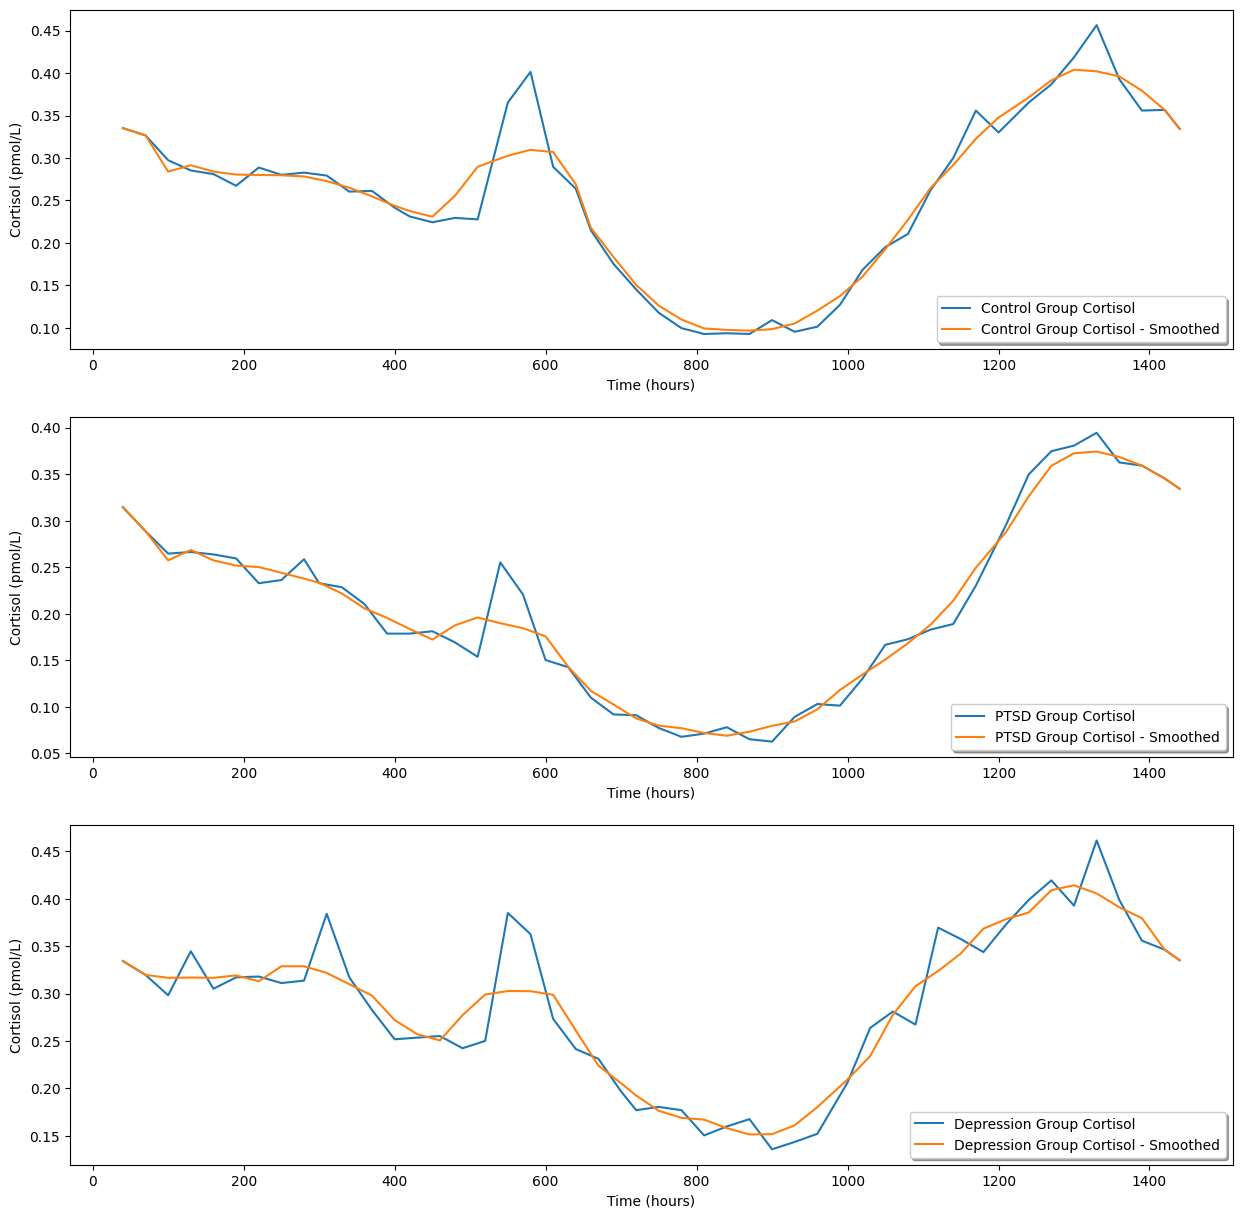

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15,15))

ax1.plot(yehuda.controlCortisol[:,0], yehuda.controlCortisol[:,1], label = "Control Group Cortisol")
ax1.plot(yehuda.controlCortisol_smooth[:,0], yehuda.controlCortisol_smooth[:,1], label = "Control Group Cortisol - Smoothed")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (pmol/L)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(yehuda.PTSDCortisol[:,0], yehuda.PTSDCortisol[:,1], label = "PTSD Group Cortisol")
ax2.plot(yehuda.PTSDCortisol_smooth[:,0], yehuda.PTSDCortisol_smooth[:,1], label = "PTSD Group Cortisol - Smoothed")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (pmol/L)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(yehuda.depressedCortisol[:,0], yehuda.depressedCortisol[:,1], label = "Depression Group Cortisol")
ax3.plot(yehuda.depressedCortisol_smooth[:,0], yehuda.depressedCortisol_smooth[:,1], label = "Depression Group Cortisol - Smoothed")
ax3.set(xlabel="Time (hours)", ylabel="Cortisol (pmol/L)")
ax3.legend(loc="lower right", shadow = True, fancybox = True)


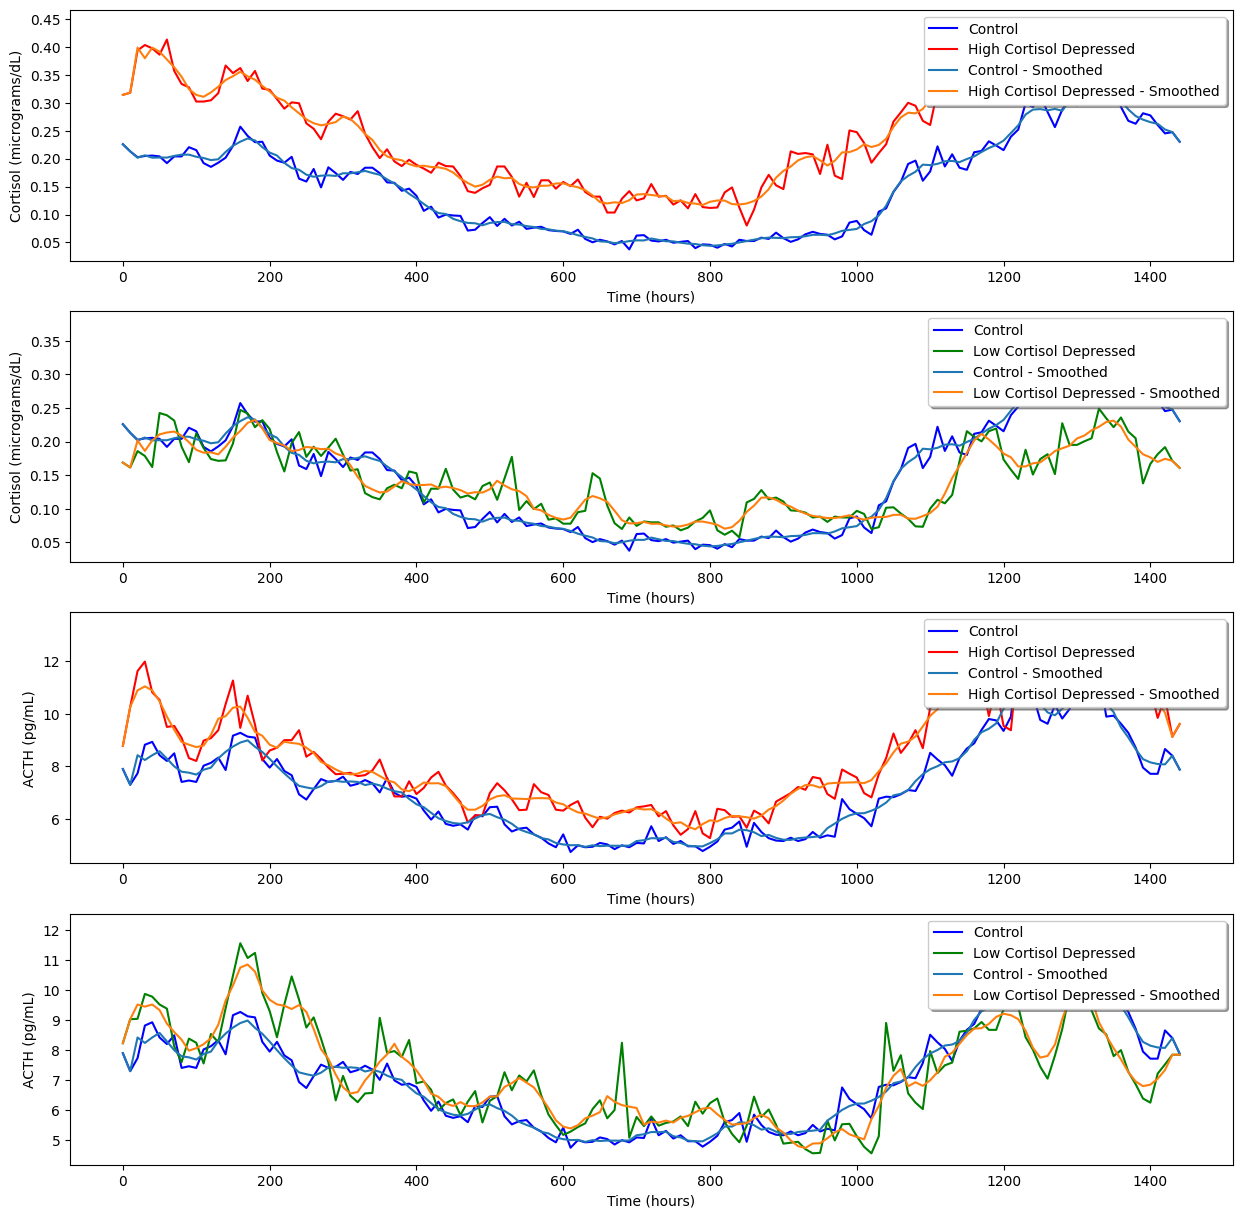

In [11]:
#mpld3.enable_notebook()
%matplotlib inline

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, figsize = (15,15))

ax1.plot(carroll.controlCortisol_rearr[:,0], carroll.controlCortisol_rearr[:,1], 'b', label = "Control")
ax1.plot(carroll.HCDepressedCortisol_rearr[:,0], carroll.HCDepressedCortisol_rearr[:,1], 'r', label = "High Cortisol Depressed")
ax1.plot(carroll.controlCortisol_rearr_smooth[:,0], carroll.controlCortisol_rearr_smooth[:,1], label = "Control - Smoothed")
ax1.plot(carroll.HCDepressedCortisol_rearr_smooth[:,0], carroll.HCDepressedCortisol_rearr_smooth[:,1], label = "High Cortisol Depressed - Smoothed")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax1.legend(loc="upper right", shadow = True, fancybox = True)

ax2.plot(carroll.controlCortisol_rearr[:,0], carroll.controlCortisol_rearr[:,1], 'b', label = "Control")
ax2.plot(carroll.LCDepressedCortisol_rearr[:,0], carroll.LCDepressedCortisol_rearr[:,1], 'g', label = "Low Cortisol Depressed")
ax2.plot(carroll.controlCortisol_rearr_smooth[:,0], carroll.controlCortisol_rearr_smooth[:,1], label = "Control - Smoothed")
ax2.plot(carroll.LCDepressedCortisol_rearr_smooth[:,0], carroll.LCDepressedCortisol_rearr_smooth[:,1], label = "Low Cortisol Depressed - Smoothed")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax2.legend(loc="upper right", shadow = True, fancybox = True)

ax3.plot(carroll.controlACTH_rearr[:,0], carroll.controlACTH_rearr[:,1], 'b', label = "Control")
ax3.plot(carroll.HCDepressedACTH_rearr[:,0], carroll.HCDepressedACTH_rearr[:,1], 'r', label = "High Cortisol Depressed")
ax3.plot(carroll.controlACTH_rearr_smooth[:,0], carroll.controlACTH_rearr_smooth[:,1], label = "Control - Smoothed")
ax3.plot(carroll.HCDepressedACTH_rearr_smooth[:,0], carroll.HCDepressedACTH_rearr_smooth[:,1], label = "High Cortisol Depressed - Smoothed")
ax3.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax3.legend(loc="upper right", shadow = True, fancybox = True)

ax4.plot(carroll.controlACTH_rearr[:,0], carroll.controlACTH_rearr[:,1], 'b', label = "Control")
ax4.plot(carroll.LCDepressedACTH_rearr[:,0], carroll.LCDepressedACTH_rearr[:,1], 'g', label = "Low Cortisol Depressed")
ax4.plot(carroll.controlACTH_rearr_smooth[:,0], carroll.controlACTH_rearr_smooth[:,1], label = "Control - Smoothed")
ax4.plot(carroll.LCDepressedACTH_rearr_smooth[:,0], carroll.LCDepressedACTH_rearr_smooth[:,1], label = "Low Cortisol Depressed - Smoothed")
ax4.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax4.legend(loc="upper right", shadow = True, fancybox = True)

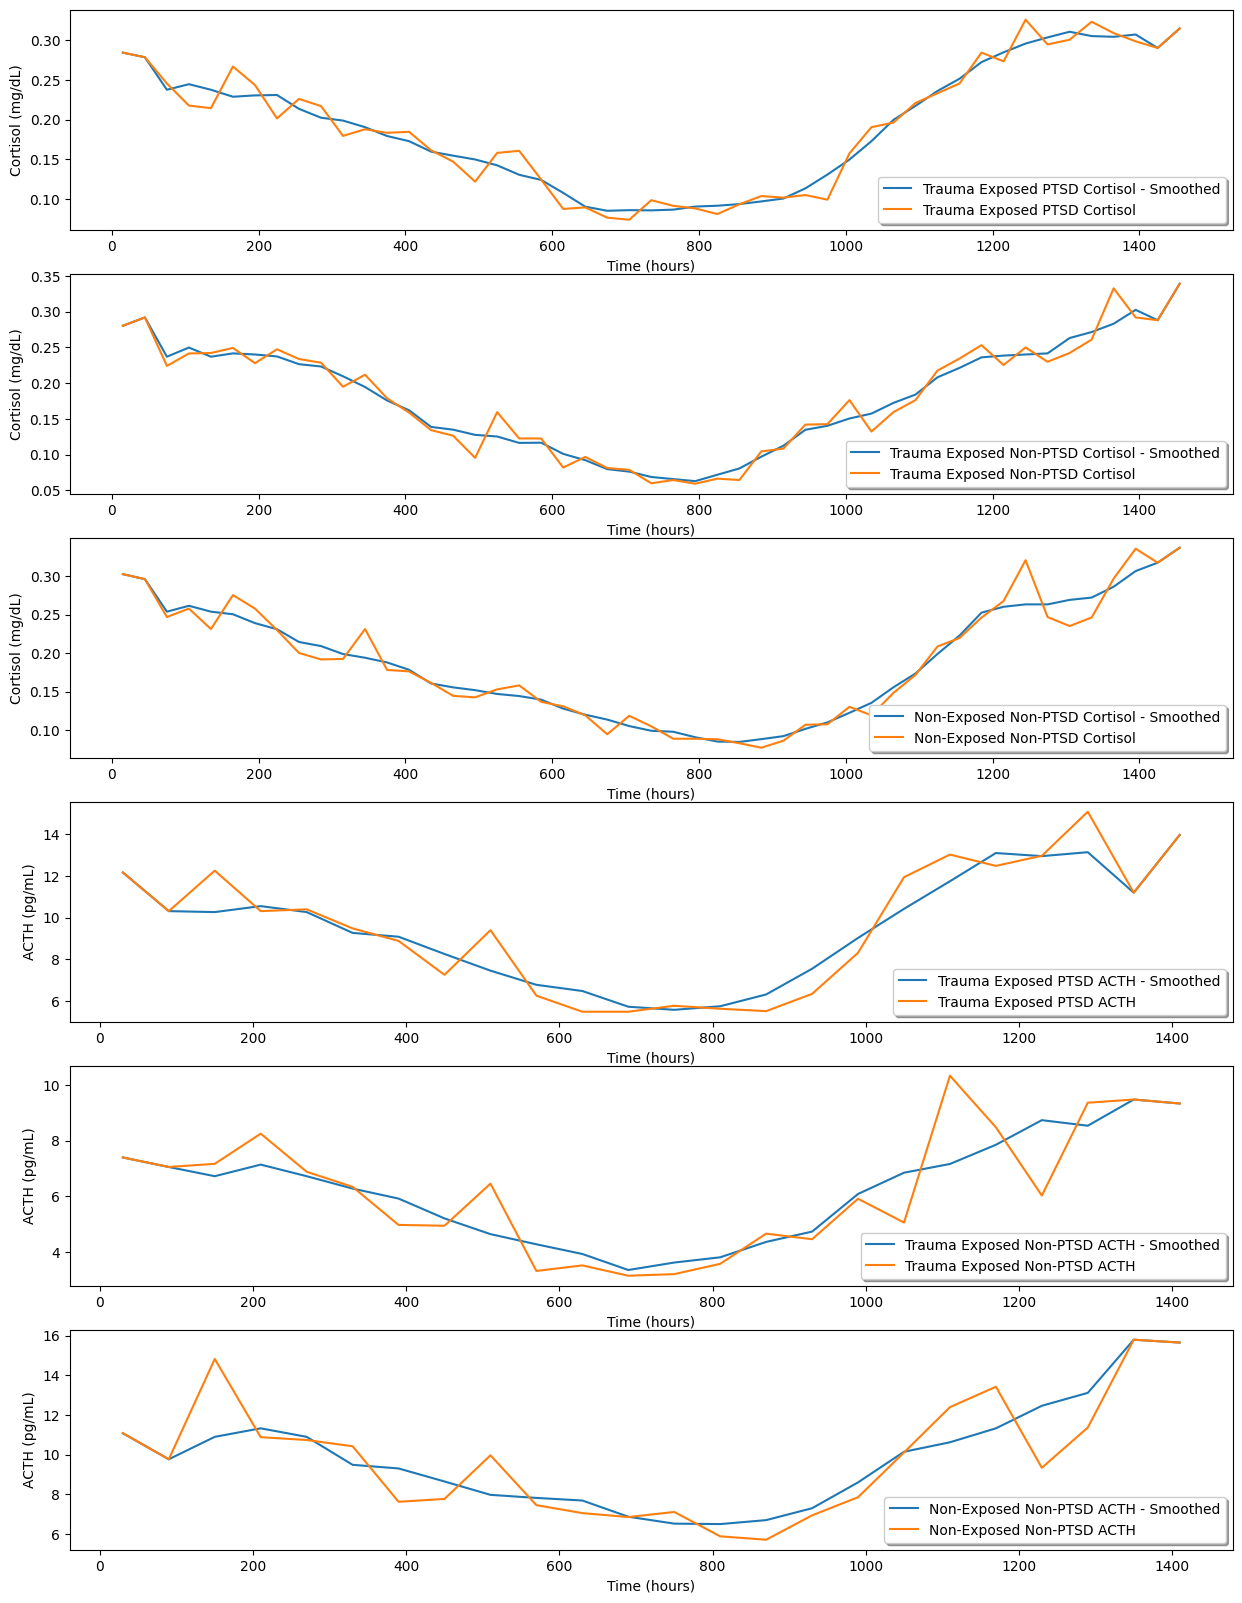

In [12]:
%matplotlib inline

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 6, figsize = (15,20))

ax1.plot(golier.PTSDCortisol_rearr_smooth[:,0], golier.PTSDCortisol_rearr_smooth[:,1], label = "Trauma Exposed PTSD Cortisol - Smoothed")
ax1.plot(golier.PTSDCortisol_rearr[:,0], golier.PTSDCortisol_rearr[:,1], label = "Trauma Exposed PTSD Cortisol")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (mg/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(golier.nonPTSDTraumaExposedCortisol_rearr_smooth[:,0], golier.nonPTSDTraumaExposedCortisol_rearr_smooth[:,1], label = "Trauma Exposed Non-PTSD Cortisol - Smoothed")
ax2.plot(golier.nonPTSDTraumaExposedCortisol_rearr[:,0], golier.nonPTSDTraumaExposedCortisol_rearr[:,1], label = "Trauma Exposed Non-PTSD Cortisol")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (mg/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(golier.nonPTSDNonExposedCortisol_rearr_smooth[:,0], golier.nonPTSDNonExposedCortisol_rearr_smooth[:,1], label = "Non-Exposed Non-PTSD Cortisol - Smoothed")
ax3.plot(golier.nonPTSDNonExposedCortisol_rearr[:,0], golier.nonPTSDNonExposedCortisol_rearr[:,1], label = "Non-Exposed Non-PTSD Cortisol")
ax3.set(xlabel="Time (hours)", ylabel="Cortisol (mg/dL)")
ax3.legend(loc="lower right", shadow = True, fancybox = True)

ax4.plot(golier.PTSDACTH_rearr_smooth[:,0], golier.PTSDACTH_rearr_smooth[:,1], label = "Trauma Exposed PTSD ACTH - Smoothed")
ax4.plot(golier.PTSDACTH_rearr[:,0], golier.PTSDACTH_rearr[:,1], label = "Trauma Exposed PTSD ACTH")
ax4.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax4.legend(loc="lower right", shadow = True, fancybox = True)

ax5.plot(golier.nonPTSDTraumaExposedACTH_rearr_smooth[:,0], golier.nonPTSDTraumaExposedACTH_rearr_smooth[:,1], label = "Trauma Exposed Non-PTSD ACTH - Smoothed")
ax5.plot(golier.nonPTSDTraumaExposedACTH_rearr[:,0], golier.nonPTSDTraumaExposedACTH_rearr[:,1], label = "Trauma Exposed Non-PTSD ACTH")
ax5.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax5.legend(loc="lower right", shadow = True, fancybox = True)

ax6.plot(golier.nonPTSDNonExposedACTH_rearr_smooth[:,0], golier.nonPTSDNonExposedACTH_rearr_smooth[:,1], label = "Non-Exposed Non-PTSD ACTH - Smoothed")
ax6.plot(golier.nonPTSDNonExposedACTH_rearr[:,0], golier.nonPTSDNonExposedACTH_rearr[:,1], label = "Non-Exposed Non-PTSD ACTH")
ax6.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax6.legend(loc="lower right", shadow = True, fancybox = True)


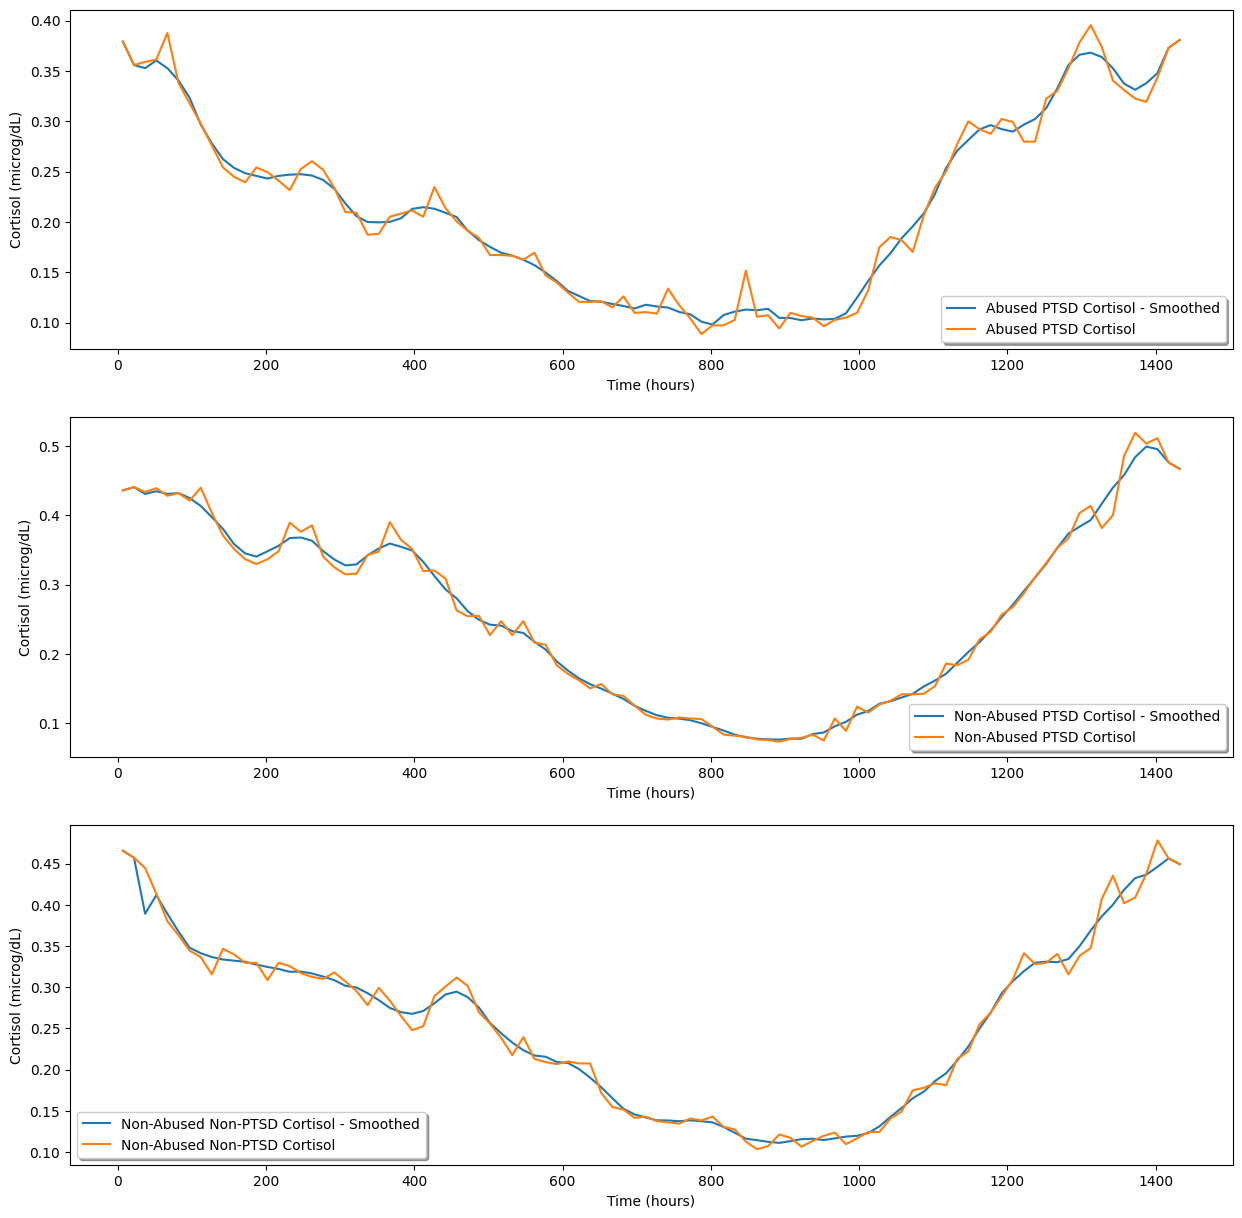

In [13]:
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15,15))

ax1.plot(bremner.abusedPTSDCortisol_rearr_smooth[:,0], bremner.abusedPTSDCortisol_rearr_smooth[:,1], label = "Abused PTSD Cortisol - Smoothed")
ax1.plot(bremner.abusedPTSDCortisol_rearr[:,0], bremner.abusedPTSDCortisol_rearr[:,1], label = "Abused PTSD Cortisol")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (microg/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(bremner.nonAbusedPTSDCortisol_rearr_smooth[:,0], bremner.nonAbusedPTSDCortisol_rearr_smooth[:,1], label = "Non-Abused PTSD Cortisol - Smoothed")
ax2.plot(bremner.nonAbusedPTSDCortisol_rearr[:,0], bremner.nonAbusedPTSDCortisol_rearr[:,1], label = "Non-Abused PTSD Cortisol")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (microg/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(bremner.nonAbusedNonPTSDCortisol_rearr_smooth[:,0], bremner.nonAbusedNonPTSDCortisol_rearr_smooth[:,1], label = "Non-Abused Non-PTSD Cortisol - Smoothed")
ax3.plot(bremner.nonAbusedNonPTSDCortisol_rearr[:,0], bremner.nonAbusedNonPTSDCortisol_rearr[:,1], label = "Non-Abused Non-PTSD Cortisol")
ax3.set(xlabel="Time (hours)", ylabel="Cortisol (microg/dL)")
ax3.legend(loc="lower left", shadow = True, fancybox = True)


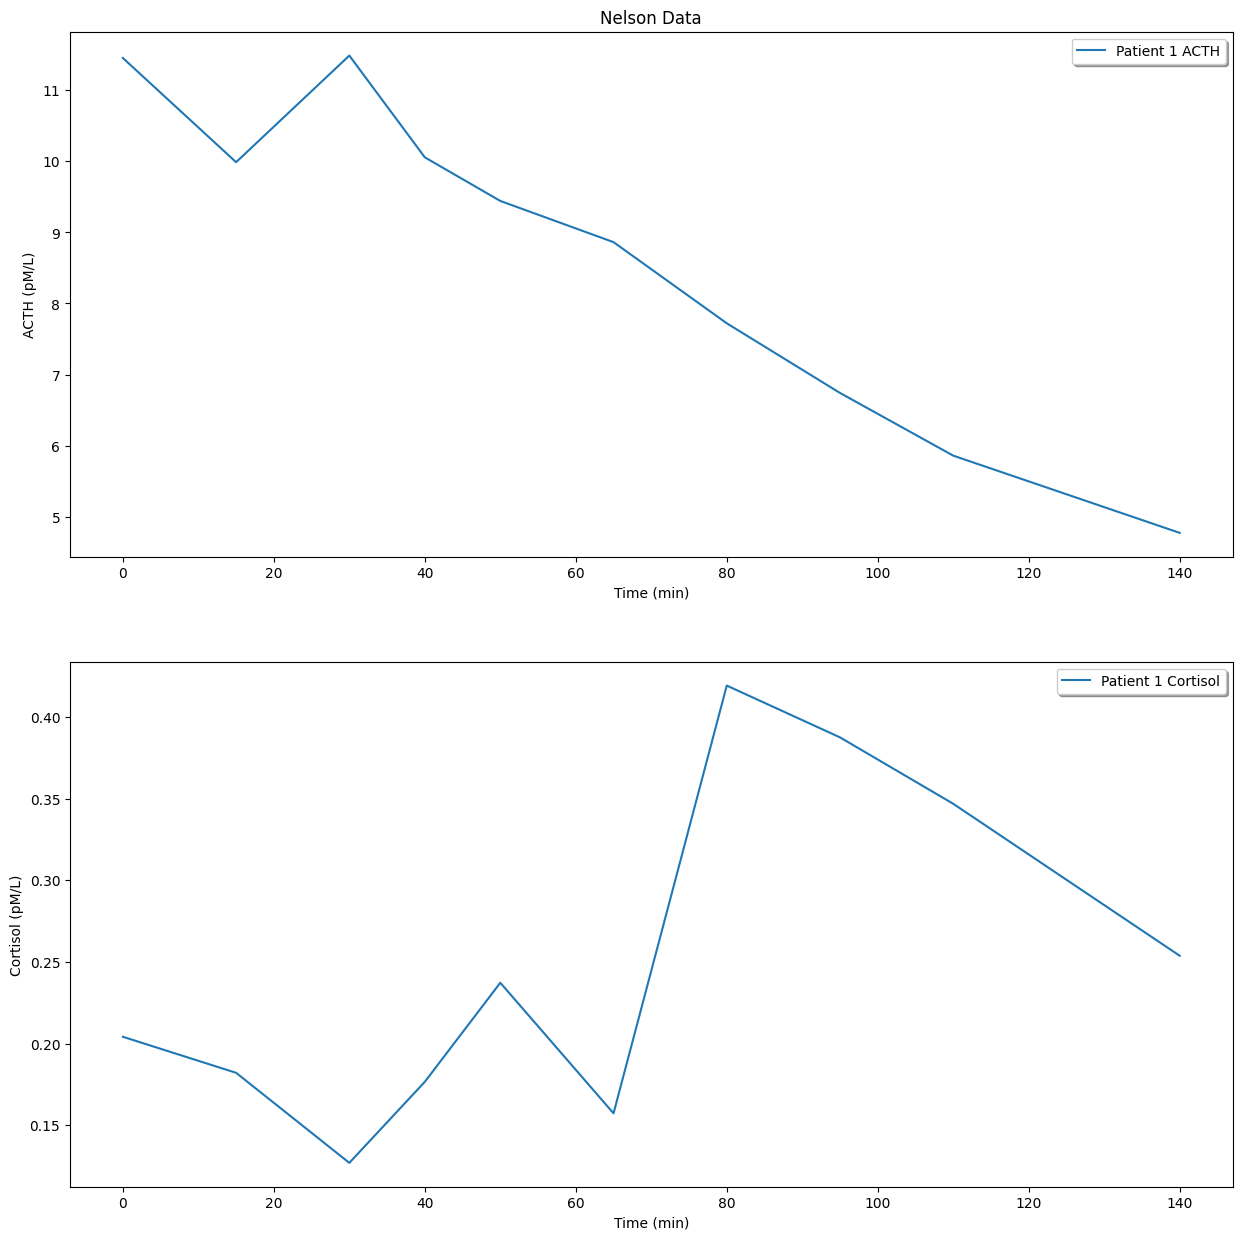

In [14]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (15, 15))

ax1.plot(nelson.ACTH[:,0], nelson.ACTH[:,2], label = "Patient 1 ACTH")
ax1.set(ylabel = "ACTH (pM/L)", xlabel = "Time (min)", title = "Nelson Data")
ax1.legend(loc="upper right", shadow = True, fancybox = True)

ax2.plot(nelson.cortisol[:,0], nelson.cortisol[:,2], label = "Patient 1 Cortisol")
ax2.set(ylabel = "Cortisol (pM/L)", xlabel = "Time (min)")
ax2.legend(loc="upper right", shadow = True, fancybox = True)

[Back to Top](#top)

# Model Function--Includes ODE Solver <a name="modelfunction"></a>

In [28]:
def model(params, ics):
    def ode_system(t, y):
        dy = np.zeros(3) # 3 equation system, R = CRH, A = ACTH, C = CORT
        
        [tau_0, tau_1, tau_2, b1, b2, b3, g1, g2, V, K, m, a1, a2] = params
        
        # differential equation definitions
        dy[0] = (a1*V)/(K + (DEsolver.delayedCORT**m)) - b1*y[0]
        dy[1] = (a2*V)/(K + (DEsolver.delayedCORT**m)) + g1*DEsolver.delayedCRH - b2*y[1]
        dy[2] = g2*DEsolver.delayedACTH - b3*y[2]
        
        return dy
    
    # Call the solve() function from my DEsolver module, and pass all of the information it needs.
    # Arguments are as follows: ODE function to solve, array of initial conditions, start time, step size, end time
    # The last three arguments are optional (leave blank for ODE systems) for delay differential equation systems, 
    #  tau0 is the delay in CRH, tau1 is the delay in ACTH, tau2 is the delay in CORT, 
    #  and delay is an array of booleans to set whether we use delays in [CRH, ACTH, CORT]
    # Normally we use 10, 30 and 60 for tau0, tau1 and tau2, respectively.
    #  But I've set them to be optimized for now.
    timeSeries = DEsolver.solve(ode_system, ics, t_start, t_step, t_end, tau0 = tau_0, tau1 = tau_1, tau2 = tau_2, delay = [True, True, True], delay_rough = True)
    return timeSeries

[Back to Top](#top)

# Cost Function Definition <a name="cost"></a>

In [27]:
def cost_fun(params):
    global y0, data_to_match
    
    # This code will optimize the first initial condition
    y0 = [params[0], y0[1], y0[2]]
    simData = model(params[1:], y0)
    
    # Comment both lines above and uncomment below to not match the IC for CRH
    # simData = model(params, y0)
    
    # To optimize ACTH as well as CRH (for use with basal data containing only cortisol concentrations), use
    #  the following lines:
    #y0 = [params[0], params[1], y0[2]]
    #simData = model(params[2:], y0)
    # Note that you'll also need to add a bound for the IC of ACTH in the list of parameter bounds
    
    return optimize.SSE_cost(data_to_match[0], data_to_match[1], data_to_match[2], data_to_match[3], simData)

[Back to Top](#top)

# Run the Optimization <a name="run"></a>

In [17]:
# Define the data set to match with the parameter optimization algorithm.
# Requires 4 indices, in the order:
# ACTH time steps, ACTH data, Cortisol time steps, Cortisol data
data_to_match = [nelson.ACTH[:,0], nelson.ACTH[:,1], nelson.cortisol[:,0], nelson.cortisol[:,1]]

# For matching data with only cortisol concentrations, use the following line and change the data sets as desired:
#data_to_match = [yehuda.controlCortisol[:,0], yehuda.controlCortisol[:,1]]

In [18]:
# We use the definition above to fill in the initial conditions for ACTH and cortisol

y0 = [0, data_to_match[1][0], data_to_match[3][0]]

# For matching data with only cortisol concentrations, use the following line and change the ICs as desired:
#y0 = [0, 10, data_to_match[1][0]]

In [19]:
opt_pars, simData_all = optimize.run(cost_fun, model, data_to_match, y0, bounds, ICopt_indices=[0], num_iter=5)

Optimization Run #1
differential_evolution step 1: f(x)= 291.299
differential_evolution step 2: f(x)= 238.157
differential_evolution step 3: f(x)= 237.682
differential_evolution step 4: f(x)= 237.682
differential_evolution step 5: f(x)= 237.682
differential_evolution step 6: f(x)= 237.682
differential_evolution step 7: f(x)= 237.682
differential_evolution step 8: f(x)= 225.853
differential_evolution step 9: f(x)= 191.615
differential_evolution step 10: f(x)= 191.615
differential_evolution step 11: f(x)= 191.615
differential_evolution step 12: f(x)= 191.615
differential_evolution step 13: f(x)= 191.615
differential_evolution step 14: f(x)= 188.875
differential_evolution step 15: f(x)= 183.836
differential_evolution step 16: f(x)= 180.807
differential_evolution step 17: f(x)= 178.112
differential_evolution step 18: f(x)= 178.112
differential_evolution step 19: f(x)= 165.474
differential_evolution step 20: f(x)= 165.474
differential_evolution step 21: f(x)= 161.396
differential_evolution 

differential_evolution step 47: f(x)= 133.374
differential_evolution step 48: f(x)= 133.374
differential_evolution step 49: f(x)= 132.279
differential_evolution step 50: f(x)= 132.279
differential_evolution step 51: f(x)= 132.279
differential_evolution step 52: f(x)= 132.279
differential_evolution step 53: f(x)= 132.279
differential_evolution step 54: f(x)= 132.279
Optimization Run #5
differential_evolution step 1: f(x)= 304.256
differential_evolution step 2: f(x)= 279.5
differential_evolution step 3: f(x)= 279.5
differential_evolution step 4: f(x)= 277.748
differential_evolution step 5: f(x)= 277.748
differential_evolution step 6: f(x)= 265.789
differential_evolution step 7: f(x)= 240.998
differential_evolution step 8: f(x)= 240.998
differential_evolution step 9: f(x)= 240.998
differential_evolution step 10: f(x)= 231.503
differential_evolution step 11: f(x)= 197.527
differential_evolution step 12: f(x)= 197.527
differential_evolution step 13: f(x)= 197.527
differential_evolution step

[Back to Top](#top)

# Save Output to File <a name="saveoutput"></a>

In [20]:
# Change the root filename, this will have the array name appended to it
#  to make the filename of the Excel files
filename_root = "bairagiModel_output/nelson-patientMean-5-iterations-ICopt"


In [21]:
# Create the pandas DataFrame object for opt_pars
# I've typed out each individual heading for the parameter names that were
#  optimized, and assigned the correct column of opt_pars to them
df_opt_pars = pd.DataFrame(opt_pars, columns=['Cost',
                                              'b1',
                                              'b2',
                                              'b3',
                                              'g1',
                                              'g2',
                                              'V',
                                              'K',
                                              'm',
                                              'a1',
                                              'a2'])

# Create the pandas DataFrame object for opt_pars
# I've typed out each individual heading for the variables and iterations,
# and assigned the correct column of simData_all to them
df_simData_all = pd.DataFrame(simData_all, columns=['Iteration 1 Time',
                                                    'Iteration 1 CRH',
                                                    'Iteration 1 ACTH',
                                                    'Iteration 1 Cortisol',
                                                    'Iteration 2 Time',
                                                    'Iteration 2 CRH',
                                                    'Iteration 2 ACTH',
                                                    'Iteration 2 Cortisol',
                                                    'Iteration 3 Time',
                                                    'Iteration 3 CRH',
                                                    'Iteration 3 ACTH',
                                                    'Iteration 3 Cortisol',
                                                    'Iteration 4 Time',
                                                    'Iteration 4 CRH',
                                                    'Iteration 4 ACTH',
                                                    'Iteration 4 Cortisol',
                                                    'Iteration 5 Time',
                                                    'Iteration 5 CRH',
                                                    'Iteration 5 ACTH',
                                                    'Iteration 5 Cortisol'])

# Create an instance of the ExcelWriter class and open the file using a with statement
with pd.ExcelWriter(filename_root+".xlsx") as writer:
    # Define the header format, so that it's bold, text is wrapped, it has a 
    #  colored background and a border
    header_format = writer.book.add_format({
        'bold': True,
        'text_wrap': True,
        'valign': 'top',
        'fg_color': '#D7E4BC',
        'border': 1
    })
    
    # Write the opt_pars array to a sheet in the file, we skip adding in the headers here and add them with the above
    #  format afterwards. We also change the row index to start at 1, rather than 0.
    df_opt_pars.index = list(range(1,len(opt_pars[:,0])+1))
    df_opt_pars.to_excel(writer, sheet_name="Optimized Parameters", startrow=1, header=False)
    
    # Write the simData_all array to another sheet in the file, we skip adding in the headers here and add them with the above
    #  format afterwards. We also disable the row index numbers, as they are not necessary here.
    df_simData_all.to_excel(writer, sheet_name="Simulated Concentration Data", startrow=1, header=False, index=False)
    
    # Loop through each header in opt_pars DataFrame and write to the sheet with formatting
    for col,val in enumerate(df_opt_pars.columns.values):
        # We write in the sheet "Optimized Parameters" in the first row, starting with the second column 
        #  (because of the row indices), using the headers from the DataFrame and the header format we defined above
        writer.sheets["Optimized Parameters"].write(0, col+1, val, header_format)
    
    # Loop through each header in simData_all DataFrame and write to the sheet with formatting
    for col,val in enumerate(df_simData_all.columns.values):
        # We write in the sheet "Simulated Concentration Data" in the first row, starting with the first column 
        #  (because we turned off the row indices), using the headers from the DataFrame and 
        #  the header format we defined above
        writer.sheets["Simulated Concentration Data"].write(0, col, val, header_format)
    

In [22]:
# Save the initial conditions and bounds to text files, also.
np.savetxt(filename_root+'-initial-conditions.txt', y0)
np.savetxt(filename_root+'-bounds.txt', bounds)

[Back to Top](#top)

# Compute Means and Std Devations of Parameters and Output as Table <a name="paramtable"></a>

In [30]:
# compute parameter means and standard deviations
b1_mean = np.mean(opt_pars[:,1])
b1_std = np.std(opt_pars[:,1])
b2_mean = np.mean(opt_pars[:,2])
b2_std = np.std(opt_pars[:,2])
b3_mean = np.mean(opt_pars[:,3])
b3_std = np.std(opt_pars[:,3])
g1_mean = np.mean(opt_pars[:,4])
g1_std = np.std(opt_pars[:,4])
g2_mean = np.mean(opt_pars[:,5])
g2_std = np.std(opt_pars[:,5])
V_mean = np.mean(opt_pars[:,6])
V_std = np.std(opt_pars[:,6])
K_mean = np.mean(opt_pars[:,7])
K_std = np.std(opt_pars[:,7])
m_mean = np.mean(opt_pars[:,8])
m_std = np.std(opt_pars[:,8])
a1_mean = np.mean(opt_pars[:,9])
a1_std = np.std(opt_pars[:,9])
a2_mean = np.mean(opt_pars[:,10])
a2_std = np.std(opt_pars[:,10])

In [31]:
# print a table of parameter means and standard deviations
print(tabulate([["b1", "%f +- %f" % (b1_mean, b1_std)], ["b2", "%f +- %f" % (b2_mean, b2_std)], ["b3", "%f +- %f" % (b3_mean, b3_std)], ["g1", "%f +- %f" % (g1_mean, g1_std)], ["g2", "%f +- %f" % (g2_mean, g2_std)], ["V", "%f +- %f" % (V_mean, V_std)], ["K", "%f +- %f" % (K_mean, K_std)], ["m", "%f +- %f" % (m_mean, m_std)], ["a1", "%f +- %f" % (a1_mean, a1_std)], ["a2", "%f +- %f" % (a2_mean, a2_std)]], headers = ["Parameter", "Mean +- Standard Deviation"]))

Parameter    Mean +- Standard Deviation
-----------  ----------------------------
b1           0.024333 +- 0.000554
b2           0.043776 +- 0.000132
b3           0.008886 +- 0.000167
g1           0.029457 +- 0.000911
g2           0.001172 +- 0.000001
V            2.705938 +- 0.007121
K            0.052260 +- 0.000813
m            2.727033 +- 0.041316
a1           0.013960 +- 0.000533
a2           0.023565 +- 0.000121


In [32]:
# save parameter means and std devs to a file
np.savetxt(filename_root+'-param-means-stds.txt', [b1_mean, b1_std, b2_mean, b2_std, b3_mean, b3_std, g1_mean, g1_std, g2_mean, g2_std, V_mean, V_std, K_mean, K_std, m_mean, m_std, a1_mean, a1_std, a2_mean, a2_std])

[Back to Top](#top)

# Plots <a name="plots"></a>

In [33]:
# Create an instance of the Visualizer object for graphing our simulations
grapher = Visualizer(globals())

In [34]:
# Because of the strange behavior of this model, we have to multiply the time steps by 3 in order to get seconds.
# Though the authors report the model in minutes, it actually seems to be in minutes*20 for some reason (based on
# verification results)
#
# So here, we will modify the time steps. We loop through a range from column 0 to the last column of simData_all,
# looking at every 4th column, as these will contain the time steps
for i in range(0, len(simData_all[0,:]), 4):
    simData_all[:,i] = [time/20 for time in simData_all[:,i]]

In [37]:
font = {'size': 18}
matplotlib.rc('font', **font)

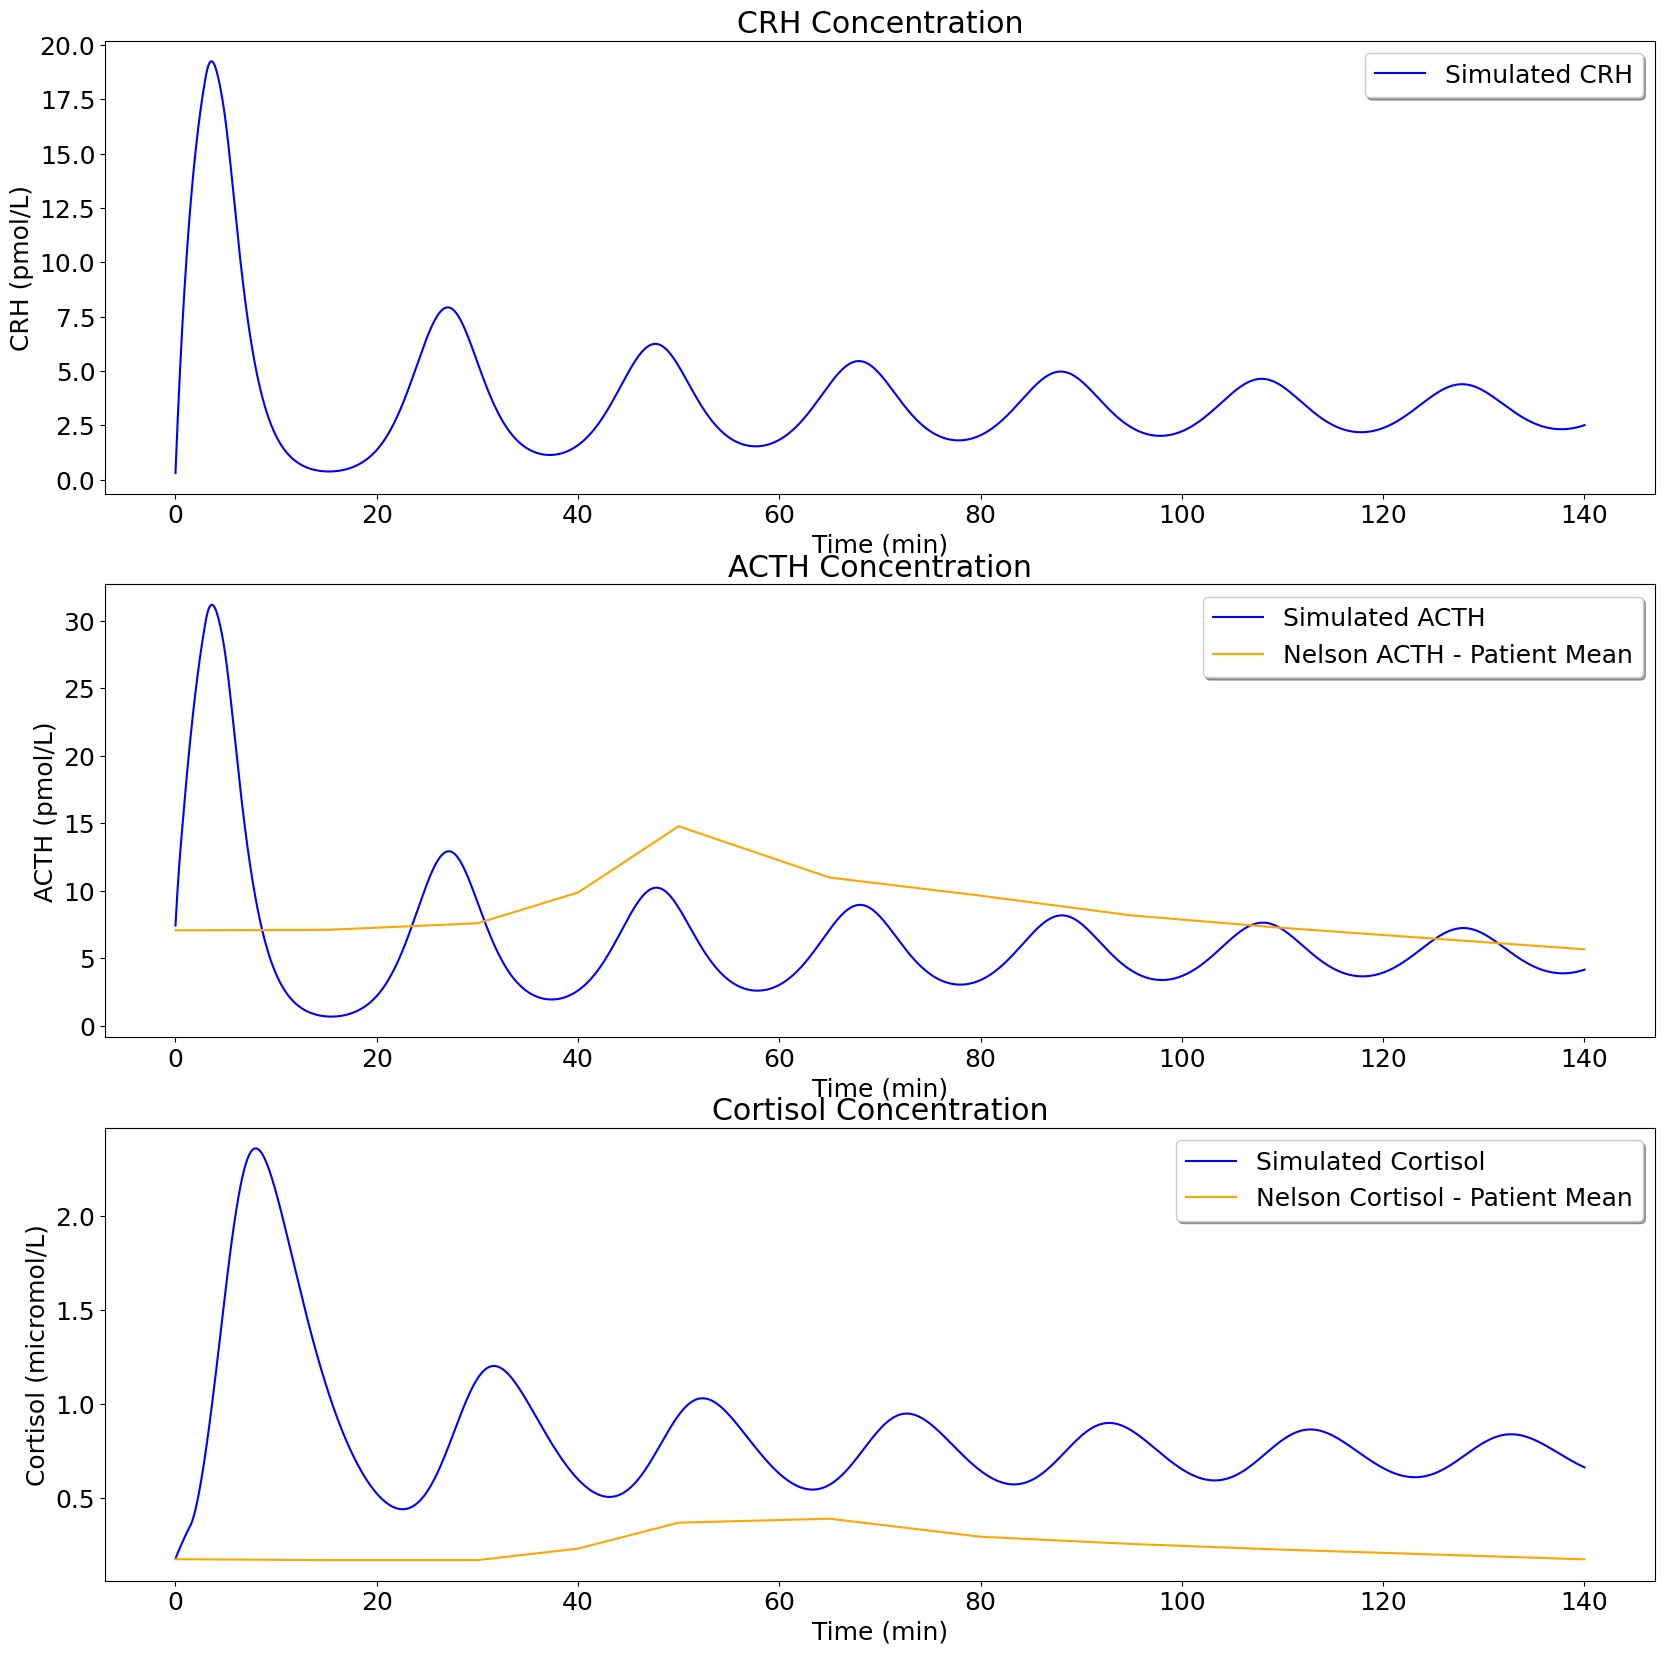

In [40]:
# Can use the Visualizer.make_graphs() method with no arguments to create simple graphs quickly. However, there are
#  a number of optional arguments that can be defined to add more information to the graphs, if desired. The arguments
#  below are for graphing CRH, ACTH and cortisol against the mean data set from the Nelson TSST data
grapher.make_graphs(yaxis_labels = ["CRH (pmol/L)", "ACTH (pmol/L)", "Cortisol (micromol/L)"],
                    xaxis_labels = ["Time (min)", "Time (min)", "Time (min)"],
                    graph_titles = ["CRH Concentration", "ACTH Concentration", "Cortisol Concentration"],
                    sims_line_labels = ["Simulated CRH", "Simulated ACTH", "Simulated Cortisol"],
                    real_data_labels = ["", "Nelson ACTH - Patient Mean", "Nelson Cortisol - Patient Mean"],
                    legend_locs = ["upper right", "upper right", "upper right"],
                    savefile = filename_root+'.png')

[Back to Top](#top)

# Reproduce Figure 2 from Paper <a name="figure2"></a>

In [ ]:
# shorten the time of iteration to see how this delay works
t_start = -0.5
t_end = 11520.5
t_step = 0.5

# set the initial conditions
y0 = [2.4, 4, 0.7]

In [ ]:
%%time

# run the solver with authors' published parameters
optimizedSimData = model(authors_params, y0)
    
# save CRH, cortisol and ACTH data into sims arrays
sims_cort = optimizedSimData[:,3]
sims_acth = optimizedSimData[:,2]
sims_crh = optimizedSimData[:,1]

In [ ]:
sims_crh_1440 = sims_crh[-4320:]
sims_acth_1440 = sims_acth[-4320:]
sims_cort_1440 = sims_cort[-4320:]

In [ ]:
%matplotlib inline
fig, (ax1) = plt.subplots(nrows = 1, figsize = (15,15))

ax1.plot(optimizedSimData[-4320:,0]/20-470, sims_crh_1440, '-', label = "CRH", )
ax1.plot(optimizedSimData[-4320:,0]/20-470, sims_acth_1440, ':', label = "ACTH")
ax1.plot(optimizedSimData[-4320:,0]/20-470, sims_cort_1440, '--', label = "Cortisol")
ax1.set(ylabel = "Concentration (pmol/L)", xlabel = "Time (mins)", title = "Figure 2 Reproduction")
ax1.legend(loc = "upper right", shadow = True, fancybox = True)

plt.savefig("bairagiModel_output/bairagiModel-figure2-reproduction.png", dpi=300)

[Back to Top](#top)

# No Optimization Run <a name='no-opt' />

In [ ]:
%%time # Output the runtime of the simulation

# Using the parameters and initial conditions defined in the section labeled Parameters and Initial Conditions, run
#  a simulation of the model without parameter optimization
data_no_opt = model(authors_params, y0)

[Back to Top](#top)

# Run Optimizations for Multiple Patients <a name="runMultiple" />

In [ ]:
# Enter the patient number to start and end the optimization loop
start_patient = 1
end_patient = 10

for patient in range(start_patient, end_patient+1):
    print(f"\033[1mCurrent Patient: #{patient}\033[0m")
    # Change the data set to cycle through patients in here. Will only work for Nelson TSST data, including subtype
    #  data sets (as the basal data sets are only mean concentrations, not individual patients)
    data_to_match = [nelson.ACTH[:,0], nelson.ACTH[:,patient+1], nelson.cortisol[:,0], nelson.cortisol[:,patient+1]]
    y0 = [1, data_to_match[1][0], data_to_match[3][0]]
    
    opt_pars_tmp, simData_all_tmp = optimize.run(cost_fun, model, data_to_match, y0, bounds, ICopt_indices=[0], num_iter=5)
    
    if patient == start_patient:
        simData_all_multiple = simData_all_tmp
        opt_pars_multiple = opt_pars_tmp
    else:
        simData_all_multiple = np.hstack((simData_all_multiple, simData_all_tmp))
        opt_pars_multiple = np.hstack((opt_pars_multiple, opt_pars_tmp))
        

[Back to Top](#top)

# Dependencies <a name="dependencies"></a>

In [ ]:
%load_ext watermark

In [ ]:
%watermark --iversions

[Back to Top](#top)